In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="bright",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 3
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"


data = {
    # "CPR and Schur only": load_data('../1/thermal_dynamic', n_newest=NUM_SIMS),
    "Many solvers": load_data("thermal_many_solvers", n_newest=NUM_SIMS),
}

save_media_path = Path("media")
save_media_path.mkdir(exist_ok=True)

Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/4/performance/thermal_many_solvers_0.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/4/performance/thermal_many_solvers_1.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/4/performance/thermal_many_solvers_2.npy


/home/firedrake/workspace/porepy_workspace/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Many solvers 248.69647932052612 66.02311873435974


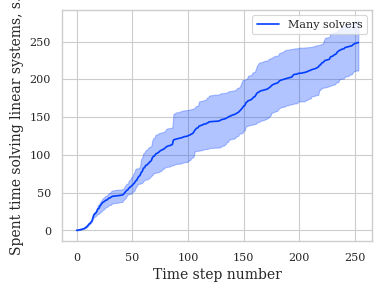

In [2]:
color_iter = -1
best_time = float("inf")
plt.figure(figsize=(4, 3))
for name, values in data.items():
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if USE_SIMULATED_TIME:
        assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

Many solvers


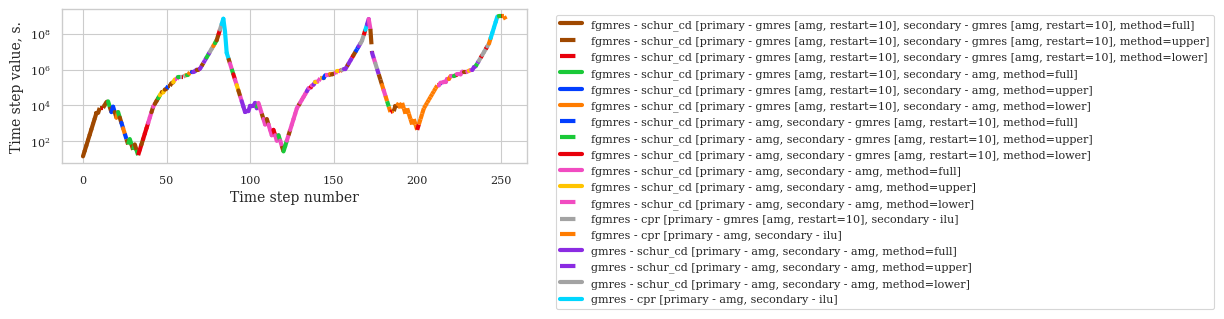

0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
2 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
3 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
4 gmres - schur_cd [primary - amg, secondary - amg, method=full]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
6 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
7 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
8 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
9 gmres - cpr [primary - amg, secondary - ilu]
10 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
11 fgmres - cpr [primary - amg, secondary - ilu]
12 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
13 fgmres - 

In [3]:
def make_solver_colors(data: Sequence[SolverSelectionData]):
    def make_hashable(x: SolverSelectionData):
        return tuple(x.prediction.decision.subsolvers.items())

    from thermal_solvers import make_thermal_solver_space

    solver_space = make_thermal_solver_space("full")
    all_solvers = solver_space.get_all_solvers()

    subsolvers = list({make_hashable(x) for x in data})
    subsolvers_to_number = {subsolver: i for i, subsolver in enumerate(subsolvers)}

    solver_names = dict()
    for subsolvers, i in subsolvers_to_number.items():
        config = None
        tested = list(dict(subsolvers).values())
        for solver_template in all_solvers:
            expected = list(solver_template.subsolvers.values())
            if tested == expected:
                config = solver_space.config_from_decision(
                    solver_template.use_defaults(), optimized_only=True
                )
                break
        assert config is not None
        solver_names[i] = solver_space.format_config(config)

    return [subsolvers_to_number[make_hashable(entry)] for entry in data], solver_names


def color_solvers(x, values, colors, names):
    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(values.size)

    names = names.copy()
    for i in range(len(x)):
        x_ = x[i : i + 2]
        val = values[i : i + 2]
        color = colors[i]
        args = {}
        if color in names:
            name = names.pop(color)
            # name = color
            args["label"] = name
        if color > 9:
            args["linestyle"] = "--"
        plt.plot(x_, val, linewidth=lw, c=f"C{color}", **args)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


for name, vals in data.items():
    colors_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    for perf in vals:
        solver_colors, solver_names = make_solver_colors(perf)
        colors_list.append(solver_colors)
        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    print(name)
    # plt.figure(figsize=(6, 2))
    # color_solvers(sim_time_list[0], inlet_rate_list[0], colors_list[0], solver_names)
    # plt.ylabel("Source rate, $m^3 s^{-1}$.")
    # plt.xlabel(X_LABEL)
    # plt.yscale("log")
    # if save_media_path is not None:
    #     plt.savefig(save_media_path / f"thermal_source_{name}.pdf", bbox_inches="tight")
    # plt.show()

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel(X_LABEL)
    color_solvers(sim_time_list[0], time_step_list[0], colors_list[0], solver_names)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_dt_{name}.pdf", bbox_inches="tight")
    plt.show()
    for i, name in solver_names.items():
        print(i, name)

Can we choose 2-3 best solvers from the bigger list of solvers?
evaluate cumulative performance prediction of pairs (or n solvers) after the simulation. 

Important thing the paper provides: the methology.
The amount of exploration is fixed for one solver. If we have more solvers, we need more exploration.

In [4]:
from tqdm import tqdm
import itertools
from solver_selector.solver_selector import make_solver_selector
from thermal_solvers import make_thermal_solver_space

solver_space = make_thermal_solver_space("full")
all_solvers = solver_space.get_all_solvers()
combinations_scores = {}
for comb in tqdm(list(itertools.combinations(range(len(all_solvers)), 2))):
    print(comb)
    solvers_to_use = all_solvers[comb[0]], all_solvers[comb[1]]
    solver_selector = make_solver_selector(
        solver_space,
        params={
            "exploration": 0,
            "load_statistics_paths": [
                "performance/thermal_many_solvers_0.npy",
            ],
        },
        solver_templates=solvers_to_use,
    )
    scores = []
    for entry in data["Many solvers"][0]:
        solver = solver_selector.select_solver(entry.prediction.context)
        expected_score = solver.score
        scores.append(expected_score)
    combinations_scores[comb] = scores

  0%|          | 0/153 [00:00<?, ?it/s]

(0, 1)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 49 / 254 data points.


  1%|          | 1/153 [00:00<01:20,  1.89it/s]

(0, 2)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 42 / 254 data points.


  1%|▏         | 2/153 [00:00<01:05,  2.31it/s]

(0, 3)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 40 / 254 data points.


  2%|▏         | 3/153 [00:01<00:56,  2.66it/s]

(0, 4)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 32 / 254 data points.


  3%|▎         | 4/153 [00:01<00:49,  3.00it/s]

(0, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 34 / 254 data points.


  3%|▎         | 5/153 [00:01<00:48,  3.03it/s]

(0, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 32 / 254 data points.


  4%|▍         | 6/153 [00:02<00:46,  3.13it/s]

(0, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 34 / 254 data points.


  5%|▍         | 7/153 [00:02<00:44,  3.30it/s]

(0, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 33 / 254 data points.


  5%|▌         | 8/153 [00:02<00:45,  3.22it/s]

(0, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 68 / 254 data points.


  6%|▌         | 9/153 [00:02<00:44,  3.26it/s]

(0, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 35 / 254 data points.


  7%|▋         | 10/153 [00:03<00:41,  3.43it/s]

(0, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 41 / 254 data points.


  7%|▋         | 11/153 [00:03<00:40,  3.53it/s]

(0, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 29 / 254 data points.


  8%|▊         | 12/153 [00:03<00:38,  3.62it/s]

(0, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 61 / 254 data points.


  8%|▊         | 13/153 [00:04<00:44,  3.13it/s]

(0, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 49 / 254 data points.


  9%|▉         | 14/153 [00:04<00:46,  3.01it/s]

(0, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 33 / 254 data points.


 10%|▉         | 15/153 [00:04<00:44,  3.13it/s]

(0, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 38 / 254 data points.


 10%|█         | 16/153 [00:05<00:42,  3.25it/s]

(0, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 36 / 254 data points.


 11%|█         | 17/153 [00:05<00:39,  3.43it/s]

(1, 2)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 37 / 254 data points.


 12%|█▏        | 18/153 [00:05<00:40,  3.35it/s]

(1, 3)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 35 / 254 data points.


 12%|█▏        | 19/153 [00:05<00:39,  3.36it/s]

(1, 4)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 27 / 254 data points.


 13%|█▎        | 20/153 [00:06<00:39,  3.35it/s]

(1, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 29 / 254 data points.


 14%|█▎        | 21/153 [00:06<00:42,  3.09it/s]

(1, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 27 / 254 data points.


 14%|█▍        | 22/153 [00:07<00:48,  2.71it/s]

(1, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 29 / 254 data points.


 15%|█▌        | 23/153 [00:07<00:52,  2.47it/s]

(1, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 28 / 254 data points.


 16%|█▌        | 24/153 [00:08<00:53,  2.42it/s]

(1, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 63 / 254 data points.


 16%|█▋        | 25/153 [00:08<00:50,  2.55it/s]

(1, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 30 / 254 data points.


 17%|█▋        | 26/153 [00:08<00:45,  2.78it/s]

(1, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 36 / 254 data points.


 18%|█▊        | 27/153 [00:09<00:46,  2.74it/s]

(1, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 24 / 254 data points.


 18%|█▊        | 28/153 [00:09<00:41,  2.99it/s]

(1, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 56 / 254 data points.


 19%|█▉        | 29/153 [00:09<00:38,  3.21it/s]

(1, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 44 / 254 data points.


 20%|█▉        | 30/153 [00:09<00:38,  3.19it/s]

(1, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 28 / 254 data points.


 20%|██        | 31/153 [00:10<00:37,  3.30it/s]

(1, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 33 / 254 data points.


 21%|██        | 32/153 [00:10<00:36,  3.35it/s]

(1, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 31 / 254 data points.


 22%|██▏       | 33/153 [00:10<00:35,  3.37it/s]

(2, 3)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 28 / 254 data points.


 22%|██▏       | 34/153 [00:11<00:38,  3.13it/s]

(2, 4)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 20 / 254 data points.


 23%|██▎       | 35/153 [00:11<00:37,  3.15it/s]

(2, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 22 / 254 data points.


 24%|██▎       | 36/153 [00:11<00:39,  2.95it/s]

(2, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 20 / 254 data points.


 24%|██▍       | 37/153 [00:12<00:46,  2.49it/s]

(2, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 22 / 254 data points.


 25%|██▍       | 38/153 [00:12<00:53,  2.17it/s]

(2, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 21 / 254 data points.


 25%|██▌       | 39/153 [00:13<00:56,  2.00it/s]

(2, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 56 / 254 data points.


 26%|██▌       | 40/153 [00:13<00:52,  2.15it/s]

(2, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 23 / 254 data points.


 27%|██▋       | 41/153 [00:14<00:48,  2.32it/s]

(2, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 29 / 254 data points.


 27%|██▋       | 42/153 [00:14<00:44,  2.51it/s]

(2, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 17 / 254 data points.


 28%|██▊       | 43/153 [00:15<00:43,  2.53it/s]

(2, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 49 / 254 data points.


 29%|██▉       | 44/153 [00:15<00:42,  2.59it/s]

(2, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 37 / 254 data points.


 29%|██▉       | 45/153 [00:15<00:40,  2.64it/s]

(2, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 21 / 254 data points.


 30%|███       | 46/153 [00:16<00:39,  2.68it/s]

(2, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 26 / 254 data points.


 31%|███       | 47/153 [00:16<00:39,  2.66it/s]

(2, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 24 / 254 data points.


 31%|███▏      | 48/153 [00:17<00:44,  2.36it/s]

(3, 4)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 18 / 254 data points.


 32%|███▏      | 49/153 [00:17<00:46,  2.23it/s]

(3, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 20 / 254 data points.


 33%|███▎      | 50/153 [00:17<00:45,  2.26it/s]

(3, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 18 / 254 data points.


 33%|███▎      | 51/153 [00:18<00:45,  2.25it/s]

(3, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 20 / 254 data points.


 34%|███▍      | 52/153 [00:18<00:40,  2.51it/s]

(3, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 19 / 254 data points.


 35%|███▍      | 53/153 [00:18<00:36,  2.72it/s]

(3, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 54 / 254 data points.


 35%|███▌      | 54/153 [00:19<00:32,  3.00it/s]

(3, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 21 / 254 data points.


 36%|███▌      | 55/153 [00:19<00:30,  3.22it/s]

(3, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 27 / 254 data points.


 37%|███▋      | 56/153 [00:19<00:28,  3.43it/s]

(3, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 15 / 254 data points.


 37%|███▋      | 57/153 [00:19<00:26,  3.63it/s]

(3, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 47 / 254 data points.


 38%|███▊      | 58/153 [00:20<00:26,  3.65it/s]

(3, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 35 / 254 data points.


 39%|███▊      | 59/153 [00:20<00:24,  3.80it/s]

(3, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 19 / 254 data points.


 39%|███▉      | 60/153 [00:20<00:23,  3.95it/s]

(3, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 24 / 254 data points.


 40%|███▉      | 61/153 [00:21<00:26,  3.47it/s]

(3, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 22 / 254 data points.


 41%|████      | 62/153 [00:21<00:27,  3.37it/s]

(4, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 12 / 254 data points.


 41%|████      | 63/153 [00:21<00:31,  2.88it/s]

(4, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 10 / 254 data points.


 42%|████▏     | 64/153 [00:22<00:32,  2.75it/s]

(4, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 12 / 254 data points.


 42%|████▏     | 65/153 [00:22<00:34,  2.55it/s]

(4, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 11 / 254 data points.


 43%|████▎     | 66/153 [00:23<00:33,  2.64it/s]

(4, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 46 / 254 data points.


 44%|████▍     | 67/153 [00:23<00:32,  2.62it/s]

(4, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 13 / 254 data points.


 44%|████▍     | 68/153 [00:23<00:31,  2.70it/s]

(4, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 19 / 254 data points.


 45%|████▌     | 69/153 [00:24<00:29,  2.81it/s]

(4, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 7 / 254 data points.


 46%|████▌     | 70/153 [00:24<00:27,  3.03it/s]

(4, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 39 / 254 data points.


 46%|████▋     | 71/153 [00:24<00:25,  3.26it/s]

(4, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 27 / 254 data points.


 47%|████▋     | 72/153 [00:24<00:23,  3.39it/s]

(4, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 11 / 254 data points.


 48%|████▊     | 73/153 [00:25<00:23,  3.47it/s]

(4, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 16 / 254 data points.


 48%|████▊     | 74/153 [00:25<00:22,  3.54it/s]

(4, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 14 / 254 data points.


 49%|████▉     | 75/153 [00:25<00:21,  3.68it/s]

(5, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 12 / 254 data points.


 50%|████▉     | 76/153 [00:26<00:22,  3.35it/s]

(5, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 14 / 254 data points.


 50%|█████     | 77/153 [00:26<00:21,  3.57it/s]

(5, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 13 / 254 data points.


 51%|█████     | 78/153 [00:26<00:20,  3.68it/s]

(5, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 48 / 254 data points.


 52%|█████▏    | 80/153 [00:27<00:18,  3.98it/s]

(5, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 15 / 254 data points.


 53%|█████▎    | 81/153 [00:27<00:17,  4.17it/s]

(5, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 21 / 254 data points.
(5, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 54%|█████▎    | 82/153 [00:27<00:16,  4.32it/s]

Used 9 / 254 data points.
(5, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 54%|█████▍    | 83/153 [00:27<00:15,  4.42it/s]

Used 41 / 254 data points.
(5, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 55%|█████▍    | 84/153 [00:27<00:15,  4.47it/s]

Used 29 / 254 data points.
(5, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 56%|█████▌    | 85/153 [00:28<00:15,  4.44it/s]

Used 13 / 254 data points.
(5, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 18 / 254 data points.


 56%|█████▌    | 86/153 [00:28<00:15,  4.23it/s]

(5, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 16 / 254 data points.


 57%|█████▋    | 87/153 [00:28<00:16,  4.10it/s]

(6, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 12 / 254 data points.


 58%|█████▊    | 88/153 [00:28<00:16,  4.01it/s]

(6, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 11 / 254 data points.


 58%|█████▊    | 89/153 [00:29<00:18,  3.50it/s]

(6, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 46 / 254 data points.


 59%|█████▉    | 90/153 [00:29<00:17,  3.56it/s]

(6, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 13 / 254 data points.


 59%|█████▉    | 91/153 [00:29<00:17,  3.61it/s]

(6, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 19 / 254 data points.


 60%|██████    | 92/153 [00:30<00:16,  3.60it/s]

(6, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 7 / 254 data points.


 61%|██████    | 93/153 [00:30<00:17,  3.53it/s]

(6, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 39 / 254 data points.


 61%|██████▏   | 94/153 [00:30<00:17,  3.40it/s]

(6, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 27 / 254 data points.


 62%|██████▏   | 95/153 [00:31<00:16,  3.44it/s]

(6, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 11 / 254 data points.


 63%|██████▎   | 96/153 [00:31<00:16,  3.39it/s]

(6, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 16 / 254 data points.


 63%|██████▎   | 97/153 [00:31<00:16,  3.40it/s]

(6, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 14 / 254 data points.


 64%|██████▍   | 98/153 [00:31<00:16,  3.38it/s]

(7, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 13 / 254 data points.


 65%|██████▍   | 99/153 [00:32<00:15,  3.48it/s]

(7, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 48 / 254 data points.


 65%|██████▌   | 100/153 [00:32<00:15,  3.45it/s]

(7, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 15 / 254 data points.


 66%|██████▌   | 101/153 [00:32<00:14,  3.53it/s]

(7, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 21 / 254 data points.


 67%|██████▋   | 103/153 [00:33<00:13,  3.71it/s]

(7, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 9 / 254 data points.
(7, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 68%|██████▊   | 104/153 [00:33<00:12,  3.92it/s]

Used 41 / 254 data points.
(7, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 29 / 254 data points.


 69%|██████▊   | 105/153 [00:33<00:12,  3.97it/s]

(7, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 13 / 254 data points.


 70%|██████▉   | 107/153 [00:34<00:10,  4.36it/s]

(7, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 18 / 254 data points.
(7, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 16 / 254 data points.


 71%|███████   | 108/153 [00:34<00:10,  4.25it/s]

(8, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 47 / 254 data points.


 71%|███████   | 109/153 [00:34<00:11,  3.83it/s]

(8, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 14 / 254 data points.


 72%|███████▏  | 110/153 [00:34<00:11,  3.88it/s]

(8, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 20 / 254 data points.


 73%|███████▎  | 111/153 [00:35<00:10,  3.93it/s]

(8, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 8 / 254 data points.


 73%|███████▎  | 112/153 [00:35<00:11,  3.49it/s]

(8, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 40 / 254 data points.


 74%|███████▍  | 113/153 [00:35<00:11,  3.53it/s]

(8, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 28 / 254 data points.


 75%|███████▍  | 114/153 [00:36<00:10,  3.63it/s]

(8, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 12 / 254 data points.


 75%|███████▌  | 115/153 [00:36<00:10,  3.75it/s]

(8, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 17 / 254 data points.


 76%|███████▌  | 116/153 [00:36<00:10,  3.44it/s]

(8, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 15 / 254 data points.


 76%|███████▋  | 117/153 [00:36<00:10,  3.46it/s]

(9, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 49 / 254 data points.


 77%|███████▋  | 118/153 [00:37<00:09,  3.53it/s]

(9, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 55 / 254 data points.


 78%|███████▊  | 119/153 [00:37<00:09,  3.67it/s]

(9, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 43 / 254 data points.


 78%|███████▊  | 120/153 [00:37<00:08,  3.80it/s]

(9, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 75 / 254 data points.


 80%|███████▉  | 122/153 [00:38<00:07,  4.21it/s]

(9, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 63 / 254 data points.
(9, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 80%|████████  | 123/153 [00:38<00:06,  4.35it/s]

Used 47 / 254 data points.
(9, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 52 / 254 data points.


 81%|████████  | 124/153 [00:38<00:06,  4.48it/s]

(9, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 50 / 254 data points.


 82%|████████▏ | 125/153 [00:38<00:06,  4.43it/s]

(10, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 22 / 254 data points.


 82%|████████▏ | 126/153 [00:39<00:06,  4.50it/s]

(10, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 10 / 254 data points.


 83%|████████▎ | 127/153 [00:39<00:07,  3.67it/s]

(10, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 42 / 254 data points.


 84%|████████▎ | 128/153 [00:39<00:06,  3.71it/s]

(10, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 30 / 254 data points.


 85%|████████▍ | 130/153 [00:40<00:05,  4.15it/s]

(10, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 14 / 254 data points.
(10, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 86%|████████▌ | 131/153 [00:40<00:05,  4.39it/s]

Used 19 / 254 data points.
(10, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 17 / 254 data points.


 86%|████████▋ | 132/153 [00:40<00:04,  4.54it/s]

(11, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 16 / 254 data points.


 87%|████████▋ | 133/153 [00:40<00:04,  4.40it/s]

(11, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 48 / 254 data points.


 88%|████████▊ | 134/153 [00:41<00:04,  3.96it/s]

(11, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 36 / 254 data points.


 88%|████████▊ | 135/153 [00:41<00:04,  3.94it/s]

(11, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 20 / 254 data points.


 90%|████████▉ | 137/153 [00:41<00:03,  4.18it/s]

(11, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 25 / 254 data points.
(11, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 90%|█████████ | 138/153 [00:42<00:03,  4.28it/s]

Used 23 / 254 data points.
(12, 13)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 36 / 254 data points.


 92%|█████████▏| 140/153 [00:42<00:03,  4.16it/s]

(12, 14)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 24 / 254 data points.
(12, 15)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy


 92%|█████████▏| 141/153 [00:42<00:02,  4.41it/s]

Used 8 / 254 data points.
(12, 16)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 13 / 254 data points.


 93%|█████████▎| 142/153 [00:42<00:02,  4.52it/s]

(12, 17)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 11 / 254 data points.


 93%|█████████▎| 143/153 [00:43<00:02,  4.34it/s]

(13, 14)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 56 / 254 data points.


 94%|█████████▍| 144/153 [00:43<00:02,  4.09it/s]

(13, 15)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 40 / 254 data points.


 95%|█████████▍| 145/153 [00:43<00:02,  3.82it/s]

(13, 16)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 45 / 254 data points.


 95%|█████████▌| 146/153 [00:44<00:01,  3.63it/s]

(13, 17)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 43 / 254 data points.


 96%|█████████▌| 147/153 [00:44<00:01,  3.69it/s]

(14, 15)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 28 / 254 data points.


 97%|█████████▋| 148/153 [00:44<00:01,  3.75it/s]

(14, 16)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 33 / 254 data points.


 97%|█████████▋| 149/153 [00:44<00:01,  3.79it/s]

(14, 17)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 31 / 254 data points.


 99%|█████████▊| 151/153 [00:45<00:00,  3.96it/s]

(15, 16)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 17 / 254 data points.
(15, 17)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 15 / 254 data points.


100%|██████████| 153/153 [00:45<00:00,  3.33it/s]

(16, 17)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
performance/thermal_many_solvers_0.npy
Used 20 / 254 data points.


Best pairs of solvers:
0
fgmres - schur_cd [primary - amg, secondary - amg, method=full]
fgmres - cpr [primary - amg, secondary - ilu]

1
fgmres - cpr [primary - amg, secondary - ilu]
gmres - schur_cd [primary - amg, secondary - amg, method=full]

2
fgmres - cpr [primary - amg, secondary - ilu]
gmres - schur_cd [primary - amg, secondary - amg, method=lower]

3
fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
fgmres - cpr [primary - amg, secondary - ilu]

4
fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
fgmres - cpr [primary - amg, secondary - ilu]

5
fgmres - schur_cd [primary - amg, secondary - amg, method=full]
gmres - schur_cd [primary - amg, secondary - amg, method=full]



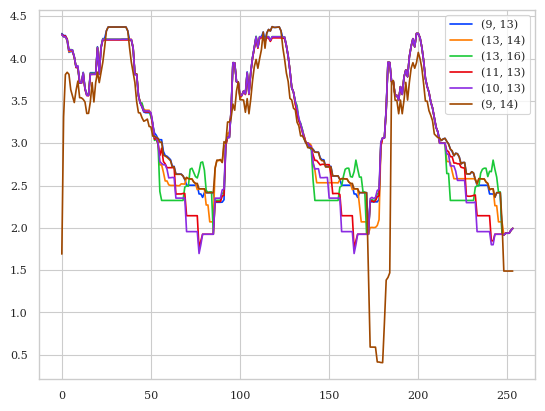

In [11]:
comb_total = {comb: sum(score) for comb, score in combinations_scores.items()}
n_best = sorted(comb_total, key=comb_total.get, reverse=True)[:6]

print("Best pairs of solvers:")
for i, comb in enumerate(n_best):
    plt.plot(combinations_scores[comb], label=comb)

    print(i)
    for id in comb:
        default = all_solvers[id].use_defaults()
        conf = solver_space.config_from_decision(decision=default, optimized_only=True)
        print(solver_space.format_config(conf))
    print()
plt.legend()

In [6]:
best_solvers_ids = list(set(item for pair in n_best for item in pair))
best_solvers = {i: all_solvers[i] for i in best_solvers_ids}

In [7]:
for i, sol in best_solvers.items():
    default = sol.use_defaults()
    conf = solver_space.config_from_decision(decision=default, optimized_only=True)
    print(i, solver_space.format_config(conf))

9 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
10 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
11 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
13 fgmres - cpr [primary - amg, secondary - ilu]
14 gmres - schur_cd [primary - amg, secondary - amg, method=full]
16 gmres - schur_cd [primary - amg, secondary - amg, method=lower]


I've got some promising results with experiment 4. I ran (only once) the thermal experiment with many possible solvers and it the framework mostly explored. Next, I did this: For each pair of solvers, I predicted the performance for the whole simulation based on those data. Then I looked at the predictions and picked the expected best pair of solvers. The results are expected / meaningful! This means, we can put a lot of options into solver selection and prune bad options for further simulations.